## Unstructured Pruning

In [4]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torchvision import datasets, transforms
import numpy as np
from collections import OrderedDict
import os
import copy
from torchsummary import summary
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.auto import tqdm 

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
DATA_DIR = './data'
WEIGHTS_URL = "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg11_bn-57d0759e.pt"
MODEL_SAVE_PATH = 'pruned_vgg11_models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
print(f"Using device: {DEVICE}")

# --- Custom VGG-11 with Batch Normalization (VGG-11_BN) Architecture for CIFAR-100 ---
# This custom definition is required to ensure the forward pass correctly handles the 32x32 input
# and the unique FC layers expected by the loaded CIFAR-100 weights.
cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
def make_layers(cfg, batch_norm=True):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG(nn.Module):
    def __init__(self, features, num_classes=100):
        super(VGG, self).__init__()
        self.features = features
        # The last MaxPool reduces 32x32 input by 2^5 = 32x factor to 1x1 feature map size.
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),  # 1x1 feature map, flattened to 512
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # 32x32 input -> 1x1x512 feature map -> flatten to 512
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])
test_dataset = datasets.CIFAR100(root=DATA_DIR, train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

original_model = VGG(make_layers(cfg, batch_norm=True), num_classes=100).to(DEVICE)
print(f"Loading weights from: {WEIGHTS_URL}...")

state_dict = torch.hub.load_state_dict_from_url(WEIGHTS_URL, map_location=DEVICE)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'): k = k[7:]
    new_state_dict[k] = v

original_model.load_state_dict(new_state_dict)
original_model.eval()


def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

original_accuracy = evaluate_model(original_model, test_loader, DEVICE)
print(f"\nOriginal VGG-11_BN (CIFAR-100) Test Accuracy: {original_accuracy:.2f}%")

PRUNABLE_LAYERS = []
print("\n--- Identifying Prunable Layers ---")
for name, module in original_model.named_modules():
    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)) and module.weight.requires_grad:
        if 'classifier.6' not in name:
            PRUNABLE_LAYERS.append((name, module))
            # --- THIS IS THE NEW PRINT STATEMENT ---
            print(f"  [FOUND] {name} ({module.__class__.__name__})")

print(f"\nFound {len(PRUNABLE_LAYERS)} prunable layers for pruning analysis.")

Using device: cuda
Loading weights from: https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg11_bn-57d0759e.pt...

Original VGG-11_BN (CIFAR-100) Test Accuracy: 70.79%

--- Identifying Prunable Layers ---
  [FOUND] features.0 (Conv2d)
  [FOUND] features.4 (Conv2d)
  [FOUND] features.8 (Conv2d)
  [FOUND] features.11 (Conv2d)
  [FOUND] features.15 (Conv2d)
  [FOUND] features.18 (Conv2d)
  [FOUND] features.22 (Conv2d)
  [FOUND] features.25 (Conv2d)
  [FOUND] classifier.0 (Linear)
  [FOUND] classifier.3 (Linear)

Found 10 prunable layers for pruning analysis.


In [5]:
print(original_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [6]:
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

def get_model_sparsity(model):
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_model_size(model, data_width=32, count_nonzero_only=False):
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()

    return num_counted_elements * data_width

# --- CIFAR-100 Training Data Loader ---
# (Required for finetuning the pruned model)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])
train_dataset = datasets.CIFAR100(root=DATA_DIR, train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def train(
  model: nn.Module,
  dataloader: torch.utils.data.DataLoader,
  criterion: nn.Module,
  optimizer: optim.Optimizer,
  scheduler: lr_scheduler._LRScheduler,
  callbacks = None
) -> None:
    model.train()
    for inputs, targets in tqdm(dataloader, desc='train', leave=False):
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if callbacks is not None:
            for callback in callbacks:
                callback()


STORED_ORIGINAL_DICT = copy.deepcopy(original_model.state_dict())

dense_model_size = get_model_size(original_model)
print(f"Dense model size: {dense_model_size / MiB:.2f} MiB")

Dense model size: 37.39 MiB


In [7]:
def plot_weight_distribution(
    model, bins=256, count_nonzero_only=False, title_prefix=""
):
    prunable_params = [
        (name, param)
        for name, param in model.named_parameters()
        if param.dim() > 1 and "classifier.6" not in name
    ]
    num_layers = len(prunable_params)

    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    axes = axes.ravel()
    plot_index = 0

    for name, param in prunable_params:
        ax = axes[plot_index]
        if count_nonzero_only:
            param_cpu = param.detach().view(-1).cpu()
            param_cpu = param_cpu[param_cpu != 0].view(-1)
            if len(param_cpu) > 0:
                ax.hist(param_cpu, bins=bins, density=True, color="blue", alpha=0.5)
        else:
            ax.hist(
                param.detach().view(-1).cpu(),
                bins=bins,
                density=True,
                color="blue",
                alpha=0.5,
            )
        ax.set_xlabel(name)
        ax.set_ylabel("density")
        plot_index += 1

    for i in range(plot_index, len(axes)):
        axes[i].axis("off")

    fig.suptitle(f"Histogram of Weights ({title_prefix})")
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)

    filename = f"weights_{title_prefix.lower().replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.show()


def unstructured_prune(tensor, sparsity):
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = int(round(num_elements * sparsity))

    if num_zeros == 0:
        return torch.ones_like(tensor)
    if num_zeros == num_elements:
        tensor.zero_()
        return torch.zeros_like(tensor)

    importance = tensor.abs()
    threshold = torch.kthvalue(importance.flatten(), k=num_zeros).values
    mask = torch.gt(importance, threshold)
    tensor.mul_(mask)

    return mask


@torch.no_grad()
def sensitivity_scan(
    model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True
):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []

    prunable_weights = [(name, module.weight) for (name, module) in PRUNABLE_LAYERS]

    num_layers = len(prunable_weights)

    for i_layer, (name, param) in enumerate(prunable_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(
            sparsities, desc=f"scanning {i_layer+1}/{num_layers} weight - {name}"
        ):
            unstructured_prune(param.detach(), sparsity=sparsity)

            acc = evaluate_model(model, dataloader, DEVICE)
            if verbose:
                print(f"\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%", end="")

            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(
                f'\r    sparsity=[{",".join([f"{x:.2f}" for x in sparsities])}]: accuracy=[{", ".join([f"{x:.2f}%" for x in accuracy])}]',
                end="",
            )
        accuracies.append(accuracy)
    return sparsities, accuracies


def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy, scan_step=0.1):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5

    # Determine the number of layers to plot
    num_layers = len(accuracies)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    axes = axes.ravel()
    plot_index = 0

    prunable_layer_names = [name for (name, module) in PRUNABLE_LAYERS]

    for i in range(num_layers):
        name = prunable_layer_names[i]
        ax = axes[plot_index]
        curve = ax.plot(sparsities, accuracies[plot_index])
        line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
        ax.set_xticks(
            np.arange(
                start=np.min(sparsities),
                stop=np.max(sparsities) + scan_step,
                step=scan_step,
            )
        )
        ax.set_ylim(
            min(10, np.min(accuracies) - 5), dense_model_accuracy + 2
        )  # Adjust ylim for potential deep drops
        ax.set_title(name)
        ax.set_xlabel("sparsity")
        ax.set_ylabel("top-1 accuracy")
        ax.legend(
            [
                "accuracy after pruning",
                f"{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy",
            ]
        )
        ax.grid(axis="x")
        plot_index += 1

    for i in range(plot_index, len(axes)):
        axes[i].axis("off")

    fig.suptitle("Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity")
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()


class UnstructuredPruner:
    def __init__(self, model, sparsity_dict):
        self.model = model
        self.sparsity_dict = sparsity_dict
        self.masks = {}

    @torch.no_grad()
    def prune(self):
        for name, module in self.model.named_modules():
            if name in self.sparsity_dict:
                param = module.weight
                sparsity = self.sparsity_dict[name]
                self.masks[f"{name}.weight"] = unstructured_prune(param, sparsity)

    @torch.no_grad()
    def apply(self):
        for name, param in self.model.named_parameters():
            if name in self.masks:
                param.data.mul_(self.masks[name])

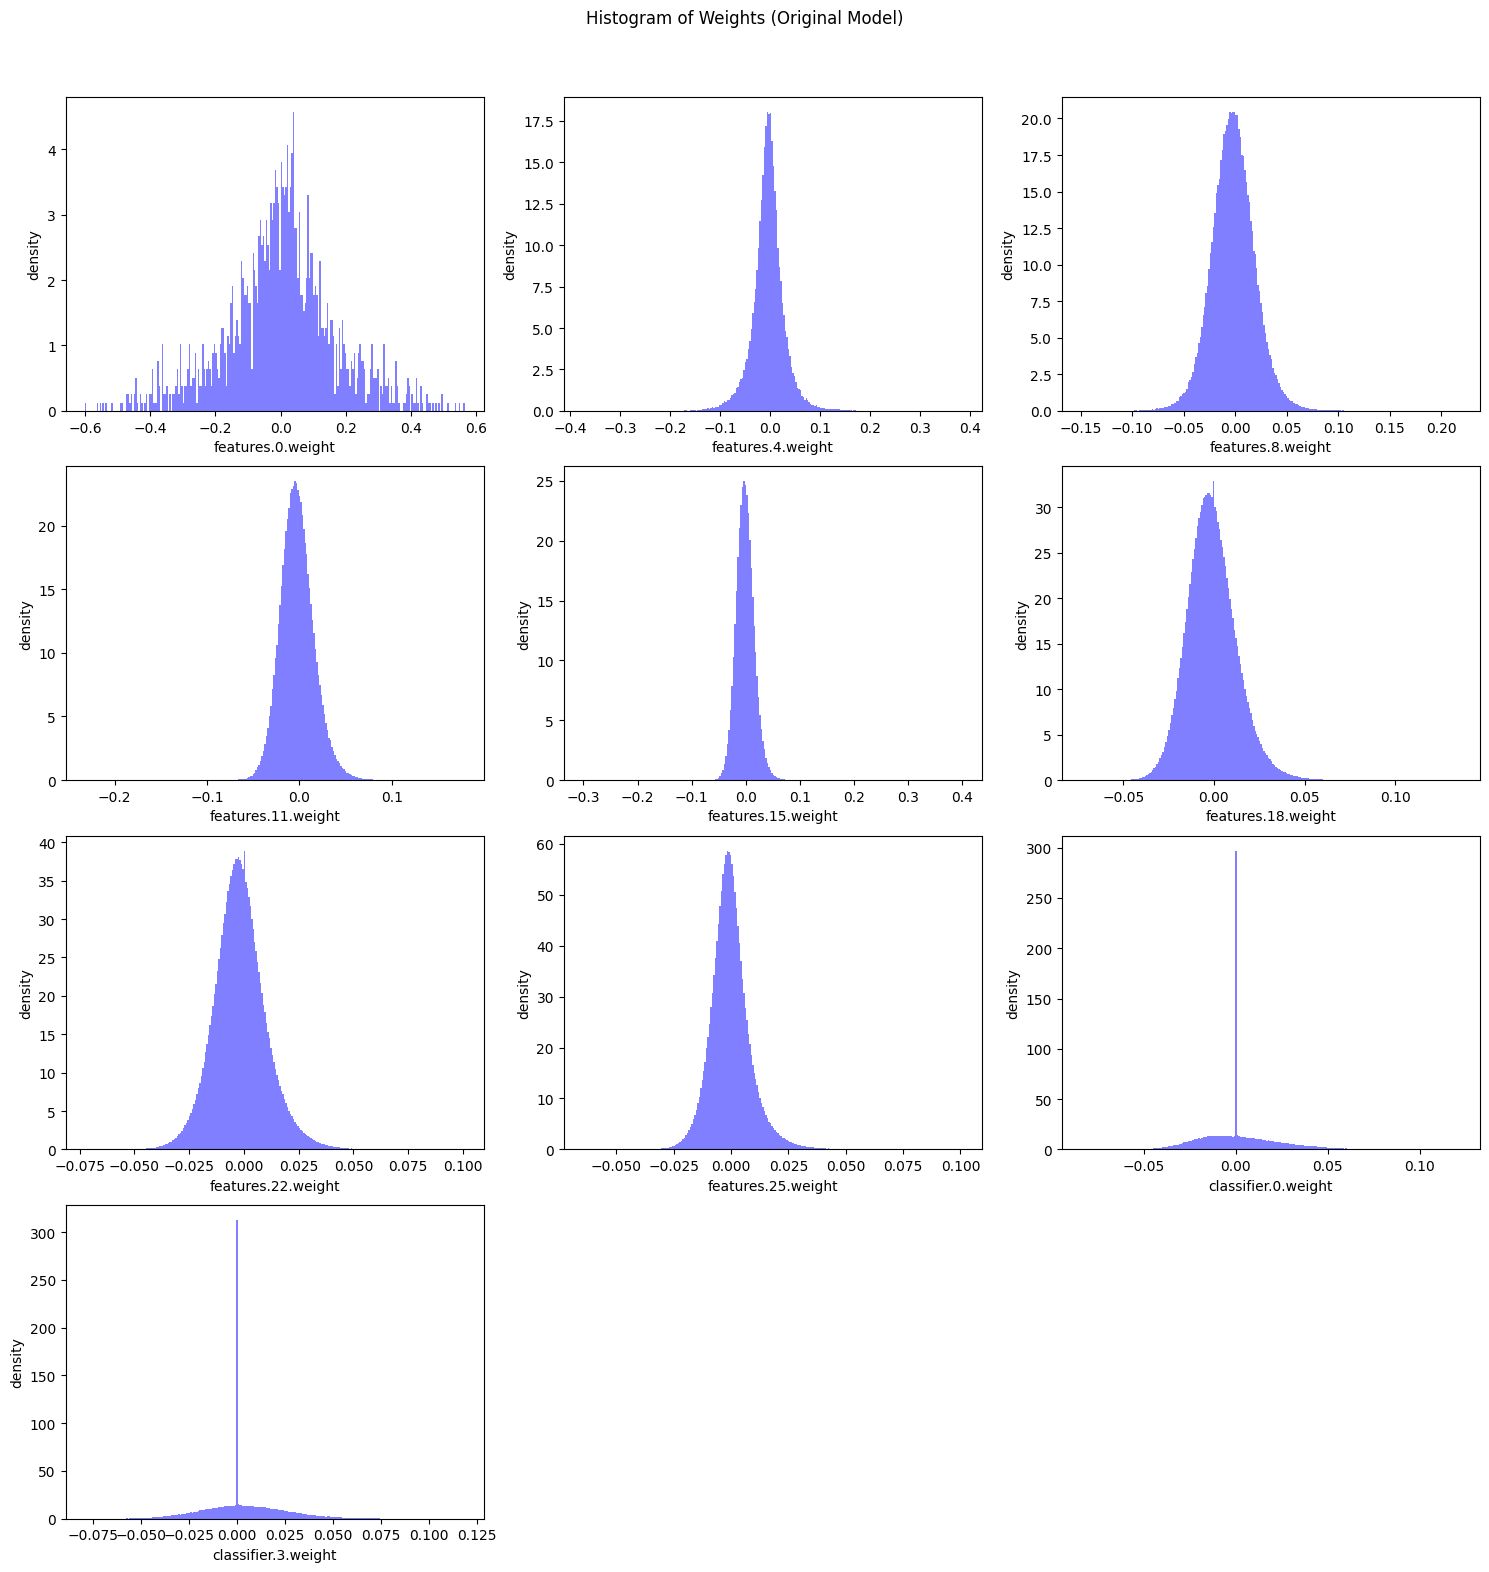

In [8]:
plot_weight_distribution(original_model, title_prefix='Original Model')

scanning 1/10 weight - features.0:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[68.90%, 63.22%, 50.27%, 29.40%, 11.95%, 4.71%]

scanning 2/10 weight - features.4:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.52%, 70.29%, 69.53%, 66.52%, 56.32%, 24.91%]

scanning 3/10 weight - features.8:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.55%, 70.36%, 69.46%, 67.09%, 56.32%, 23.51%]

scanning 4/10 weight - features.11:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.47%, 70.12%, 69.10%, 65.00%, 53.07%, 18.78%]

scanning 5/10 weight - features.15:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.77%, 70.35%, 69.66%, 68.59%, 64.03%, 45.34%]

scanning 6/10 weight - features.18:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.65%, 70.63%, 69.76%, 67.93%, 62.26%, 35.54%]

scanning 7/10 weight - features.22:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.70%, 70.74%, 70.57%, 70.44%, 69.79%, 66.05%]

scanning 8/10 weight - features.25:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.76%, 70.86%, 70.89%, 70.75%, 70.74%, 70.33%]

scanning 9/10 weight - classifier.0:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.78%, 70.79%, 70.78%, 70.73%, 70.75%, 70.21%]

scanning 10/10 weight - classifier.3:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.80%, 70.84%, 70.87%, 70.86%, 70.80%, 70.85%]

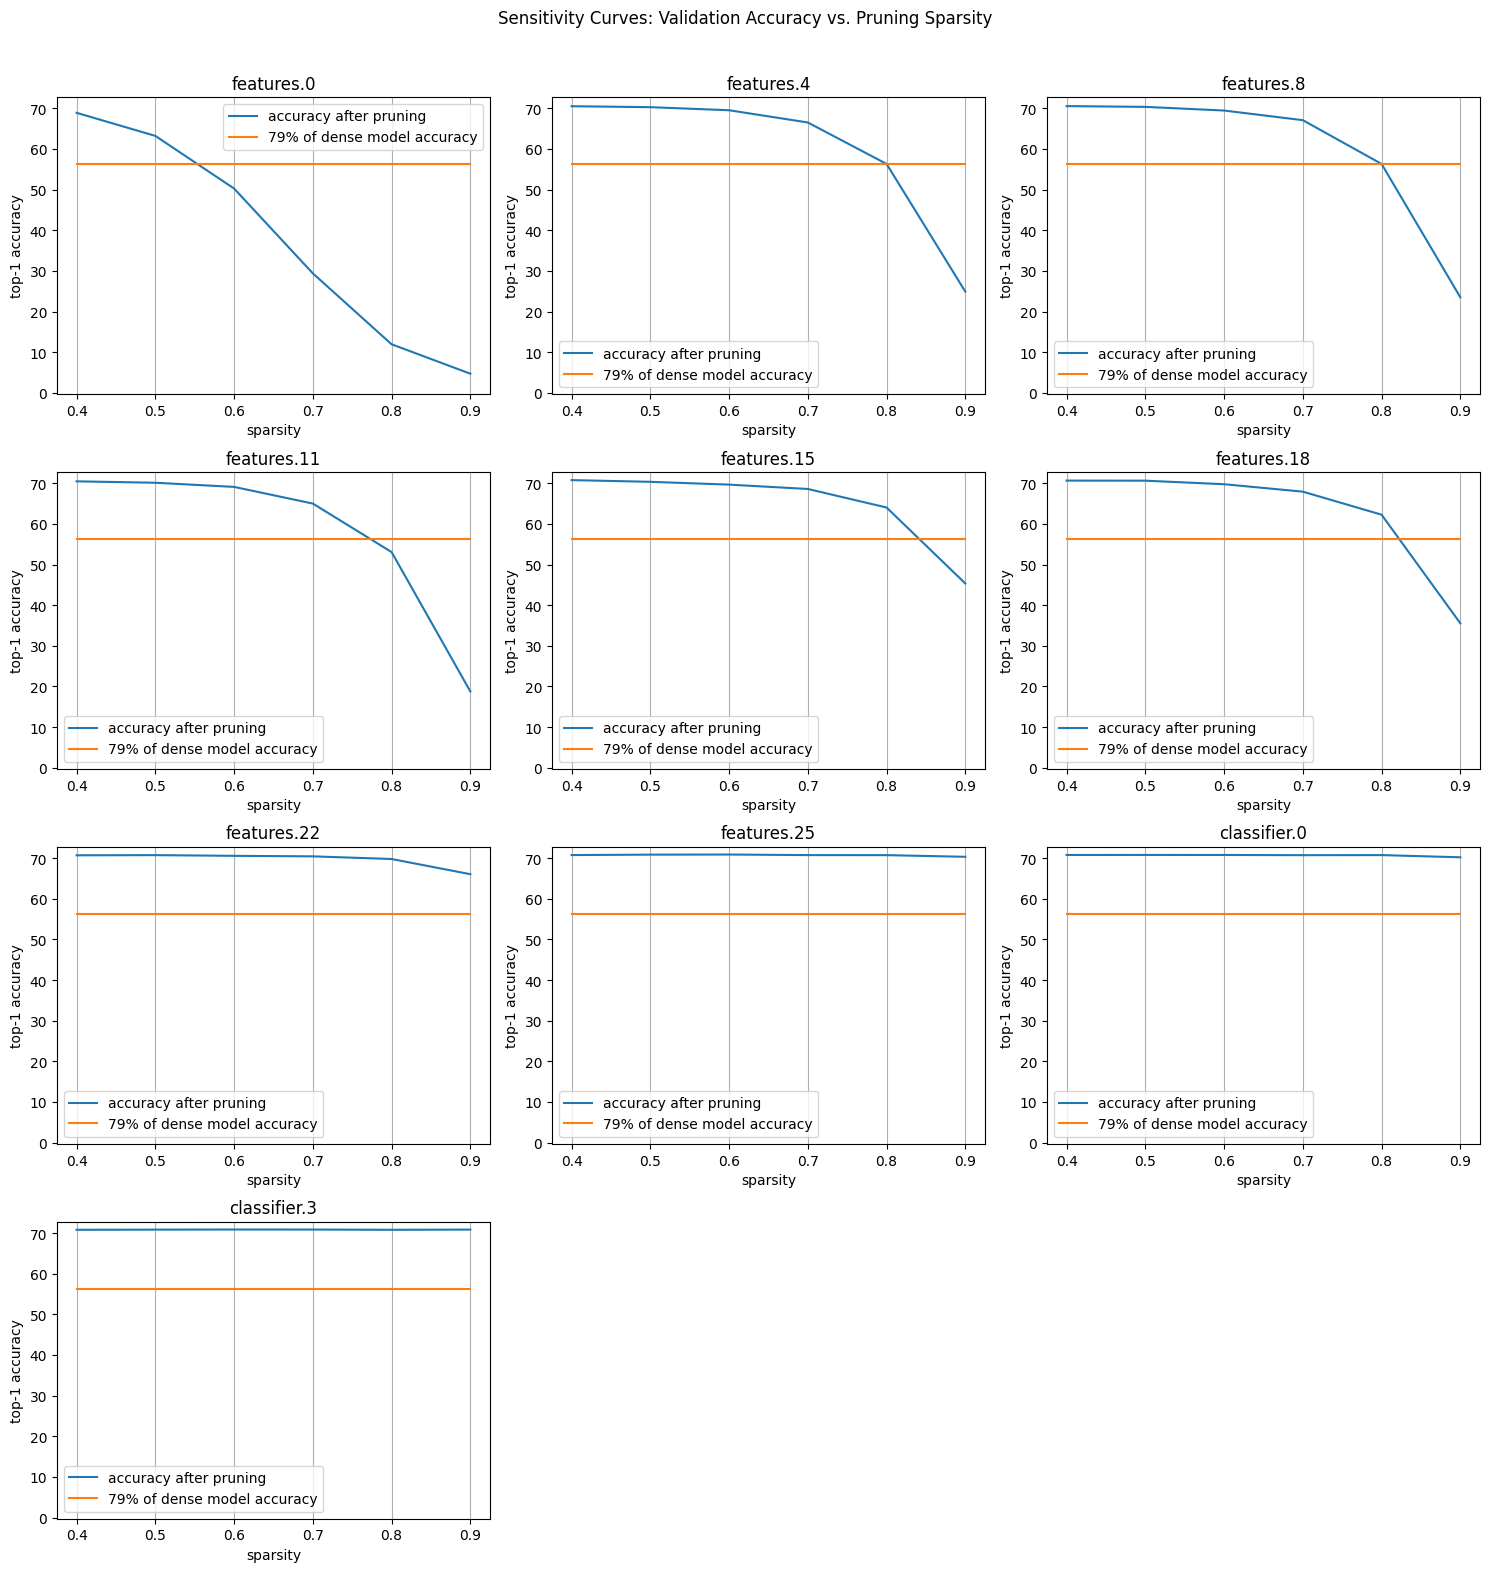

In [10]:
original_model.to(DEVICE)
original_model.load_state_dict(STORED_ORIGINAL_DICT)

scan_step=0.1
sparsities, accuracies = sensitivity_scan(
    original_model, test_loader, scan_step=scan_step, scan_start=0.4, scan_end=1.0, verbose=True
)

plot_sensitivity_scan(sparsities, accuracies, original_accuracy)

In [11]:
original_model.load_state_dict(STORED_ORIGINAL_DICT)

sparsity_dict = {
    'features.0': 0.4,
    'features.4': 0.5,
    'features.8': 0.6,
    'features.11': 0.5,
    'features.15': 0.6,
    'features.18': 0.6,
    'features.22': 0.8,
    'features.25': 0.8,
    'classifier.0': 0.8,
    'classifier.3': 0.8
}

pruner = UnstructuredPruner(original_model, sparsity_dict)

original_model.load_state_dict(STORED_ORIGINAL_DICT)
original_model.to(DEVICE)

pruner.prune()

print(f'\nSparsity of each layer after pruning:')
total_sparsity = get_model_sparsity(original_model)
for name, module in PRUNABLE_LAYERS:
    sparsity = 1 - float(module.weight.count_nonzero()) / module.weight.numel()
    print(f'  {name}.weight: {sparsity:.2f}')
print(f'\n  Overall Model Sparsity: {total_sparsity:.2f}')

sparse_model_size = get_model_size(original_model, count_nonzero_only=True)
print(f"\nUnstructured Pruned Model Size: {sparse_model_size / MiB:.2f} MiB")
print(f"Reduction: {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

sparse_model_accuracy = evaluate_model(original_model, test_loader, DEVICE)
print(f"\nUnstructured Pruned Model Accuracy: {sparse_model_accuracy:.2f}%")



Sparsity of each layer after pruning:
  features.0.weight: 0.40
  features.4.weight: 0.50
  features.8.weight: 0.60
  features.11.weight: 0.50
  features.15.weight: 0.60
  features.18.weight: 0.60
  features.22.weight: 0.80
  features.25.weight: 0.80
  classifier.0.weight: 0.80
  classifier.3.weight: 0.80

  Overall Model Sparsity: 0.70

Unstructured Pruned Model Size: 11.35 MiB
Reduction: 30.35% of dense model size

Unstructured Pruned Model Accuracy: 64.55%


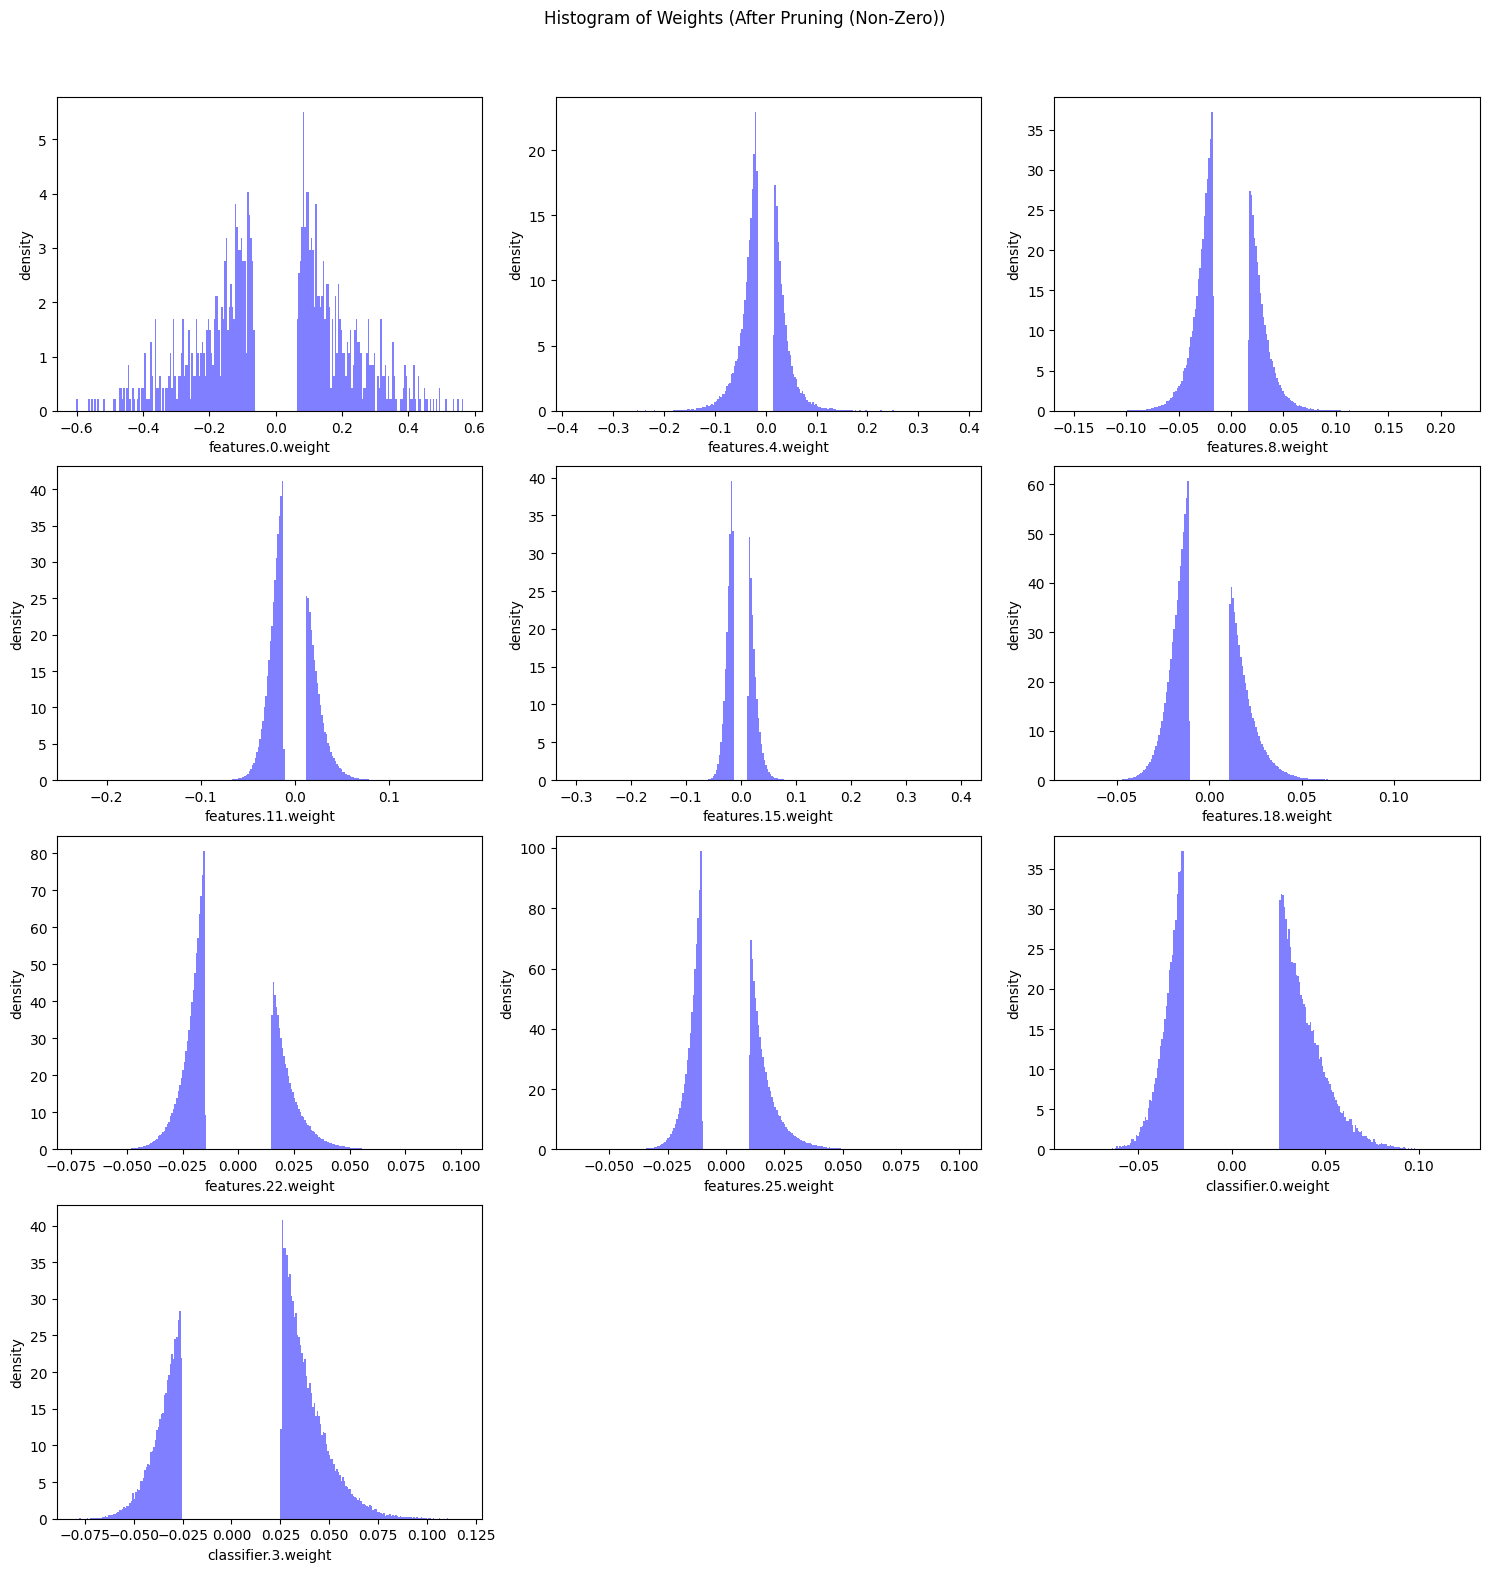

In [12]:
plot_weight_distribution(original_model, count_nonzero_only=True, title_prefix='After Pruning (Non-Zero)')

In [13]:
epochs = 3
optimizer = torch.optim.SGD(original_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs * len(train_loader))
criterion = nn.CrossEntropyLoss()

checkpoint = dict()

for epoch in range(epochs):
    train(original_model, train_loader, criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply()])
    
    accuracy = evaluate_model(original_model, test_loader, DEVICE)
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}%')

checkpoint['state_dict'] = copy.deepcopy(original_model.state_dict())

train:   0%|          | 0/391 [00:07<?, ?it/s]

    Epoch 1 Accuracy 67.85%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 2 Accuracy 69.56%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 3 Accuracy 69.82%


In [14]:
original_model.load_state_dict(checkpoint['state_dict'])
sparse_model_size = get_model_size(original_model, count_nonzero_only=True)

print(f"Unstructured Pruned Model Size: {sparse_model_size / MiB:.2f} MiB")
print(f"Reduction: {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

sparse_model_accuracy = evaluate_model(original_model, test_loader, DEVICE)
print(f"Unstructured Pruned Model Accuracy: {sparse_model_accuracy:.2f}% (after finetuning)")

Unstructured Pruned Model Size: 11.35 MiB
Reduction: 30.35% of dense model size
Unstructured Pruned Model Accuracy: 69.82% (after finetuning)


In [15]:
torch.save(checkpoint, os.path.join(MODEL_SAVE_PATH, 'unstructured_pruned_vgg11_70.pth'))

## Structured Pruning

In [16]:
import time

@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()

    for _ in range(n_warmup):
        _ = model(dummy_input)

    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)

    t2 = time.time()
    return (t2 - t1) / n_test

original_model.load_state_dict(STORED_ORIGINAL_DICT)
original_model.to(DEVICE)
original_model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [17]:
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    for i_c in range(in_channels):
        channel_weight = weight.detach()[:, i_c]
        
        importance = torch.norm(channel_weight, p=2)
        
        importances.append(importance.view(1))
    return torch.cat(importances)


@torch.no_grad()
def structured_prune_func(model: nn.Module, 
                  sparsity_dict: dict) -> nn.Module:

    model_new = copy.deepcopy(model)
    
    module_map = dict(model_new.named_modules())

    pruning_chain = [
        ('features.0',  module_map['features.0'],  module_map['features.1'],  module_map['features.4']),
        ('features.4',  module_map['features.4'],  module_map['features.5'],  module_map['features.8']),
        ('features.8',  module_map['features.8'],  module_map['features.9'],  module_map['features.11']),
        ('features.11', module_map['features.11'], module_map['features.12'], module_map['features.15']),
        ('features.15', module_map['features.15'], module_map['features.16'], module_map['features.18']),
        ('features.18', module_map['features.18'], module_map['features.19'], module_map['features.22']),
        ('features.22', module_map['features.22'], module_map['features.23'], module_map['features.25']),
        ('features.25', module_map['features.25'], module_map['features.26'], module_map['classifier.0']),
        
        ('classifier.0', module_map['classifier.0'], None, module_map['classifier.3']),
        ('classifier.3', module_map['classifier.3'], None, module_map['classifier.6']),
    ]
    
    kept_indices = None 
    
    for layer_key, prev_layer, prev_bn, next_layer in pruning_chain:
        
        if kept_indices is not None:
            prev_layer.weight.set_(torch.index_select(
                prev_layer.weight.detach(), 1, kept_indices.to(DEVICE)
            ))

            if isinstance(prev_layer, nn.Conv2d):
                prev_layer.in_channels = kept_indices.shape[0]
            elif isinstance(prev_layer, nn.Linear):
                prev_layer.in_features = kept_indices.shape[0]

        prune_ratio = sparsity_dict.get(layer_key, 0.0)
        
        if isinstance(prev_layer, nn.Conv2d):
            original_channels = prev_layer.out_channels
        else:
            original_channels = prev_layer.out_features

        n_keep = int(round(original_channels * (1. - prune_ratio)))

        if isinstance(next_layer, nn.Conv2d):
            importance = get_input_channel_importance(next_layer.weight)
        else:
            importance = torch.norm(next_layer.weight, p=2, dim=0)

        sort_idx = torch.argsort(importance, descending=True)
        kept_indices = sort_idx[:n_keep]
        
        prev_layer.weight.set_(torch.index_select(
            prev_layer.weight.detach(), 0, kept_indices.to(DEVICE)
        ))
        if prev_layer.bias is not None:
            prev_layer.bias.set_(torch.index_select(
                prev_layer.bias.detach(), 0, kept_indices.to(DEVICE)
            ))
            
        if isinstance(prev_layer, nn.Conv2d):
            prev_layer.out_channels = kept_indices.shape[0]
        elif isinstance(prev_layer, nn.Linear):
            prev_layer.out_features = kept_indices.shape[0]
            
        if prev_bn is not None:
            prev_bn.weight.set_(torch.index_select(prev_bn.weight.detach(), 0, kept_indices.to(DEVICE)))
            prev_bn.bias.set_(torch.index_select(prev_bn.bias.detach(), 0, kept_indices.to(DEVICE)))
            prev_bn.running_mean.set_(torch.index_select(prev_bn.running_mean.detach(), 0, kept_indices.to(DEVICE)))
            prev_bn.running_var.set_(torch.index_select(prev_bn.running_var.detach(), 0, kept_indices.to(DEVICE)))
            prev_bn.num_features = kept_indices.shape[0]
            
    final_layer = module_map['classifier.6']
    final_layer.weight.set_(torch.index_select(
        final_layer.weight.detach(), 1, kept_indices.to(DEVICE)
    ))
    final_layer.in_features = kept_indices.shape[0]

    return model_new

In [18]:
@torch.no_grad()
def structured_sens_scan(model, dataloader, scan_step=0.1, scan_start=0.1, scan_end=0.9, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    
    prunable_layer_names = [name for (name, module) in PRUNABLE_LAYERS]
    
    num_layers = len(prunable_layer_names)

    for i_layer, layer_name in enumerate(prunable_layer_names):
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer+1}/{num_layers} layer - {layer_name}'):
            temp_sparsity_dict = {name: 0.0 for name in prunable_layer_names}
            temp_sparsity_dict[layer_name] = sparsity
            
            pruned_model = structured_prune_func(model, temp_sparsity_dict)
            
            acc = evaluate_model(pruned_model, dataloader, DEVICE)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            accuracy.append(acc)
        
        if verbose:
            print(f'\r    sparsity=[{",".join([f"{x:.2f}" for x in sparsities])}]: accuracy=[{", ".join([f"{x:.2f}%" for x in accuracy])}]', end='')
        accuracies.append(accuracy)
        
    return sparsities, accuracies, prunable_layer_names

def plot_structured_sens_scan(sparsities, accuracies, layer_names, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    
    num_layers = len(accuracies)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    axes = axes.ravel()
    plot_index = 0

    for i in range(num_layers):
        name = layer_names[i]
        ax = axes[plot_index]
        curve = ax.plot(sparsities, accuracies[plot_index])
        line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
        ax.set_xticks(np.arange(start=np.min(sparsities), stop=np.max(sparsities) + scan_step, step=0.1))
        ax.set_ylim(min(0, np.min(accuracies) - 5), dense_model_accuracy + 2)
        ax.set_title(name)
        ax.set_xlabel('sparsity')
        ax.set_ylabel('top-1 accuracy')
        ax.legend([
            'accuracy after pruning',
            f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
        ])
        ax.grid(axis='x')
        plot_index += 1
    
    for i in range(plot_index, len(axes)):
        axes[i].axis('off')
        
    fig.suptitle('Structured Pruning Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

scanning 1/10 layer - features.0:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.78%, 69.67%, 68.04%, 63.71%, 57.10%, 43.28%, 18.38%, 9.10%, 3.73%]

scanning 2/10 layer - features.4:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.08%, 64.30%, 54.32%, 39.66%, 24.08%, 11.66%, 4.55%, 2.70%, 1.26%]

scanning 3/10 layer - features.8:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.45%, 68.84%, 65.58%, 61.05%, 51.34%, 37.81%, 23.27%, 7.95%, 2.86%]

scanning 4/10 layer - features.11:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.17%, 66.85%, 62.53%, 54.40%, 41.88%, 24.54%, 12.47%, 6.76%, 3.19%]

scanning 5/10 layer - features.15:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.22%, 68.73%, 66.27%, 63.00%, 57.40%, 49.60%, 38.06%, 18.71%, 6.61%]

scanning 6/10 layer - features.18:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.97%, 68.46%, 66.27%, 62.74%, 58.87%, 52.70%, 42.50%, 24.15%, 8.18%]

scanning 7/10 layer - features.22:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[69.98%, 68.91%, 66.79%, 64.37%, 60.10%, 54.77%, 47.34%, 34.85%, 17.44%]

scanning 8/10 layer - features.25:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.70%, 70.63%, 70.25%, 70.03%, 69.50%, 68.77%, 67.04%, 63.33%, 46.38%]

scanning 9/10 layer - classifier.0:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.79%, 70.79%, 70.65%, 70.53%, 70.05%, 69.84%, 69.12%, 67.18%, 61.85%]

scanning 10/10 layer - classifier.3:   0%|          | 0/9 [00:00<?, ?it/s]

    sparsity=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.51%, 70.46%, 70.42%, 70.08%, 69.82%, 69.98%, 69.25%, 66.76%, 64.50%]

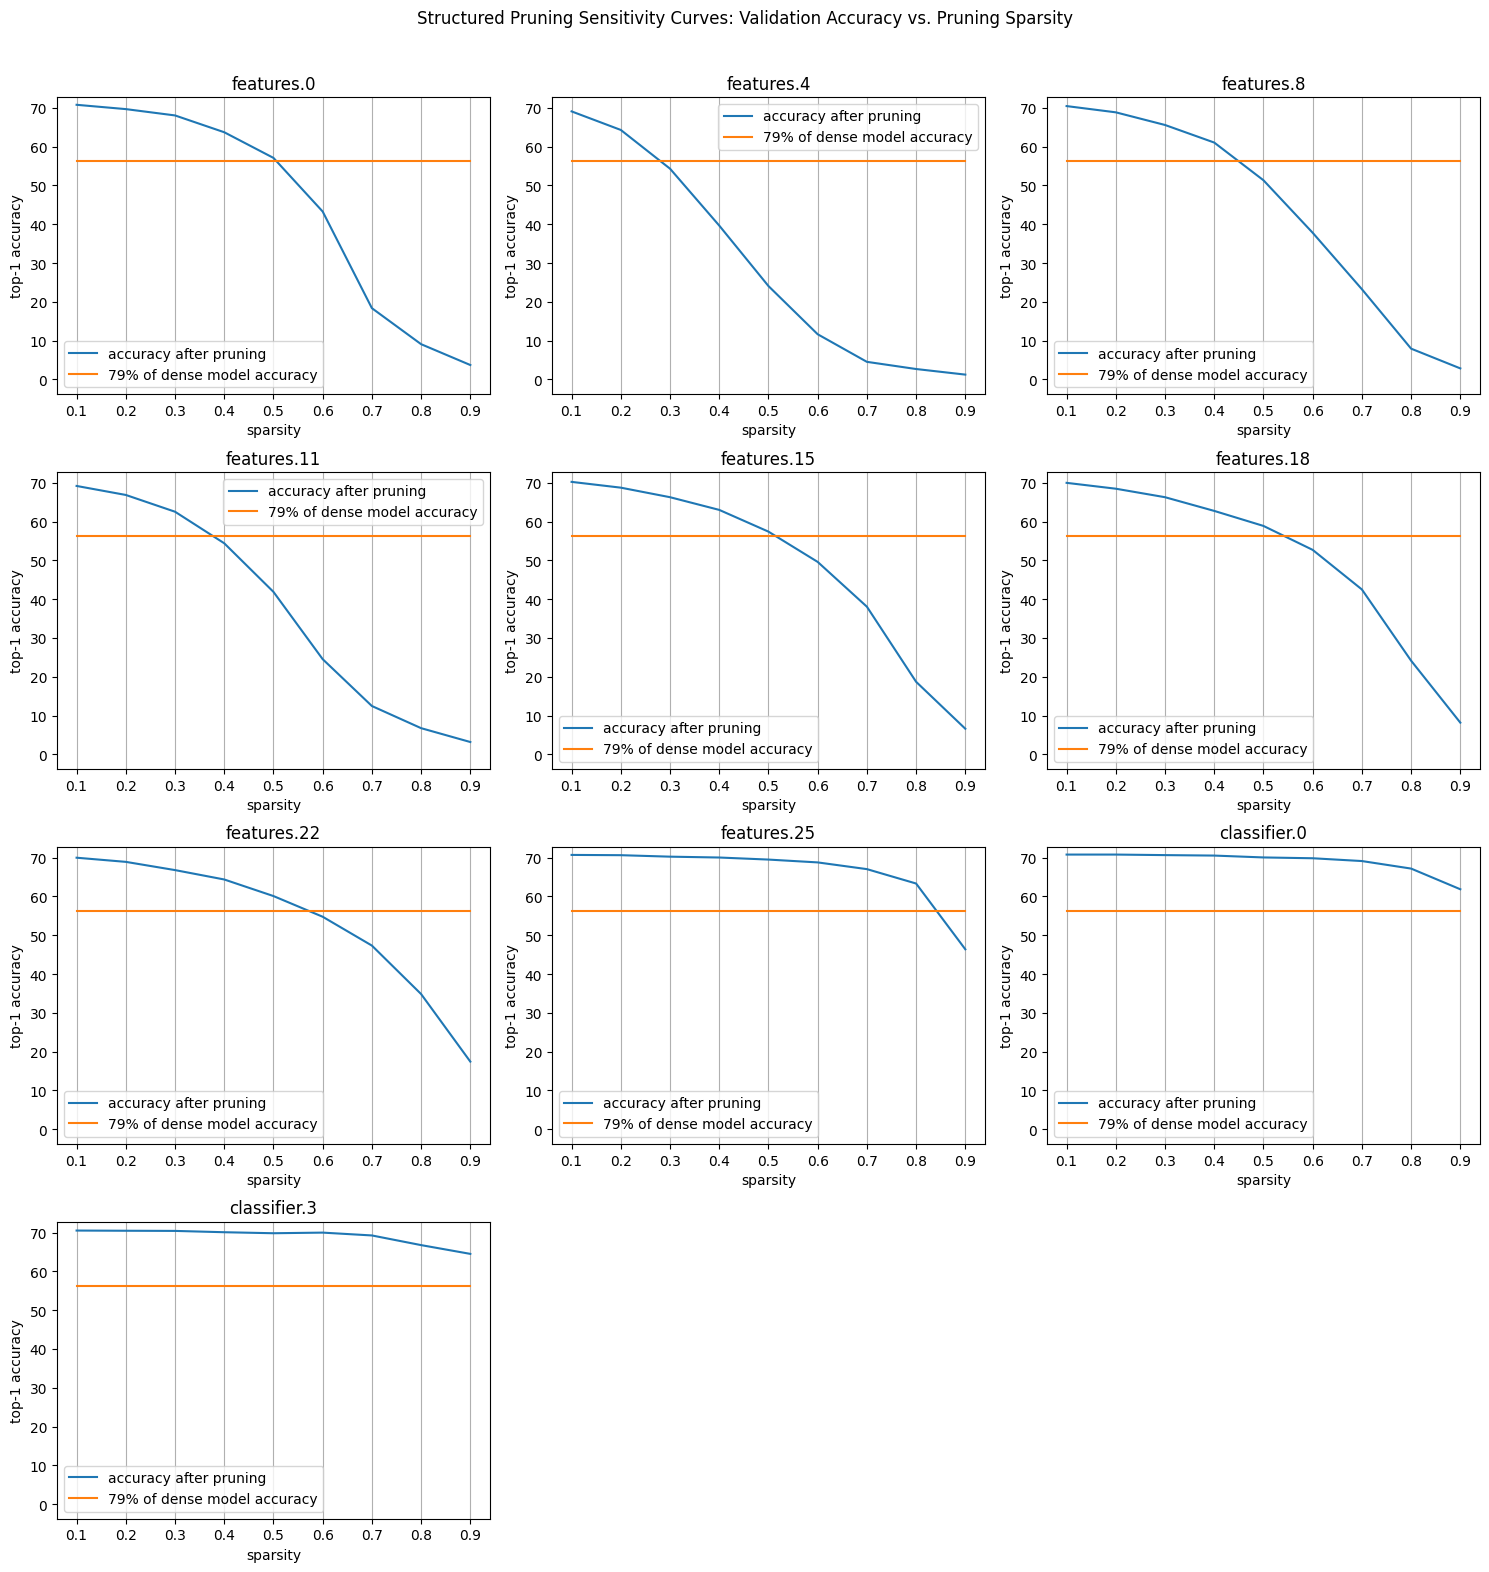

In [19]:
original_model.to(DEVICE)
original_model.load_state_dict(STORED_ORIGINAL_DICT)

scan_step=0.1

channel_sparsities, channel_accuracies, prunable_layer_names = structured_sens_scan(
    original_model, test_loader, scan_step=scan_step, scan_start=0.1, scan_end=1, verbose=True
)

plot_structured_sens_scan(channel_sparsities, channel_accuracies, prunable_layer_names, original_accuracy)

In [20]:
original_model.load_state_dict(STORED_ORIGINAL_DICT)
original_model.to(DEVICE)

sparsity_dict = {
    'features.0': 0.4,
    'features.4': 0.15,
    'features.8': 0.35,
    'features.11': 0.3,
    'features.15': 0.4,
    'features.18': 0.45,
    'features.22': 0.4,
    'features.25': 0.7,
    'classifier.0': 0.7,
    'classifier.3': 0.7
}

pruned_model = structured_prune_func(original_model, sparsity_dict=sparsity_dict)
pruned_model.to(DEVICE)

print(f'\nSparsity of each layer after pruning:')
for name, sparsity in sparsity_dict.items():
    print(f'  {name} (output): {sparsity:.2f}')

sparse_model_size = get_model_size(pruned_model, count_nonzero_only=False) 
print(f"\nStructured Pruned Model Size: {sparse_model_size / MiB:.2f} MiB")
print(f"Reduction: {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

sparse_model_accuracy = evaluate_model(pruned_model, test_loader, DEVICE)
print(f"\nStructured Pruned Model Accuracy: {sparse_model_accuracy:.2f}%")


Sparsity of each layer after pruning:
  features.0 (output): 0.40
  features.4 (output): 0.15
  features.8 (output): 0.35
  features.11 (output): 0.30
  features.15 (output): 0.40
  features.18 (output): 0.45
  features.22 (output): 0.40
  features.25 (output): 0.70
  classifier.0 (output): 0.70
  classifier.3 (output): 0.70

Structured Pruned Model Size: 11.50 MiB
Reduction: 30.76% of dense model size

Structured Pruned Model Accuracy: 7.11% (before fintuning)


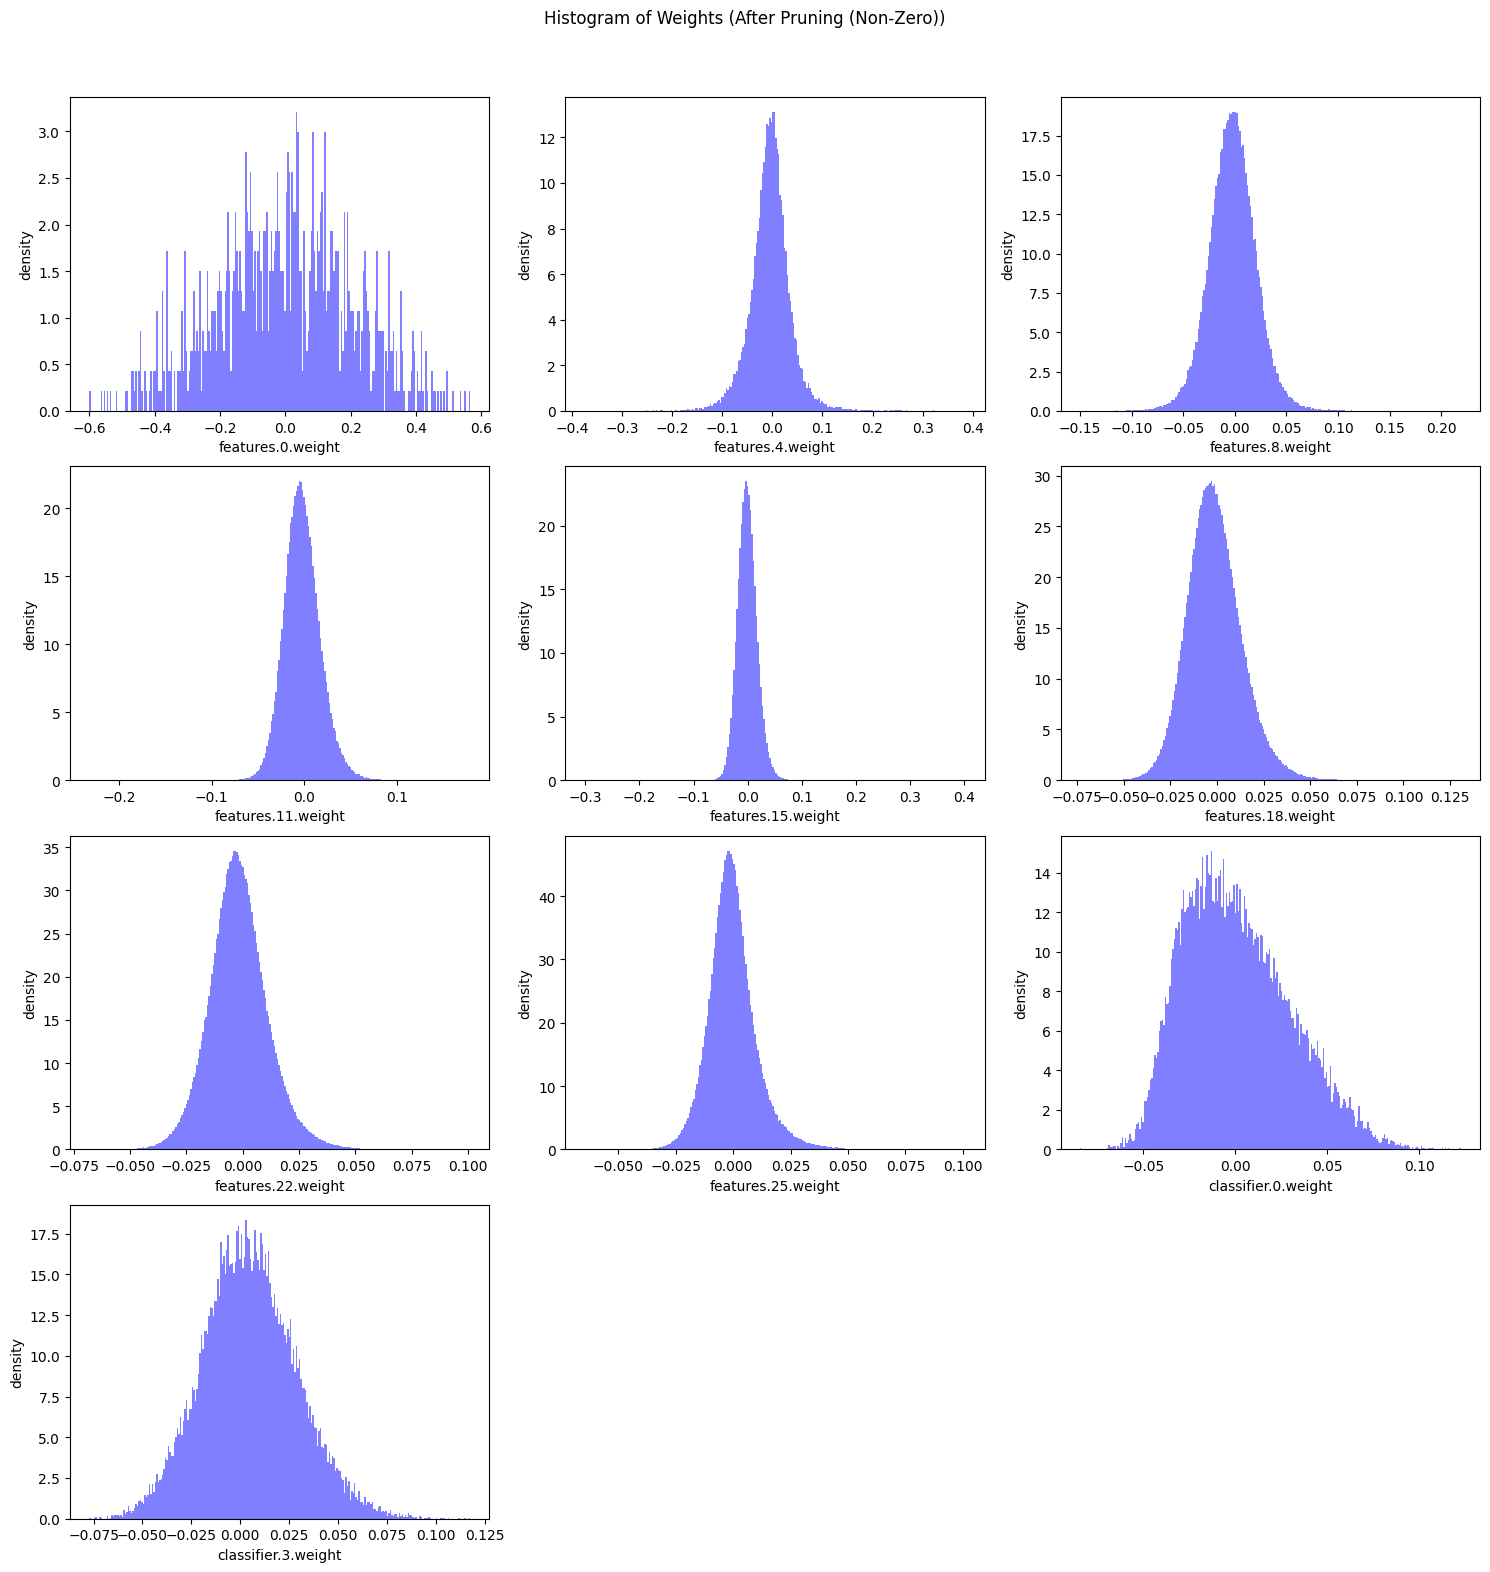

In [21]:
plot_weight_distribution(pruned_model, count_nonzero_only=True, title_prefix='After Pruning (Non-Zero)')

In [22]:
epochs = 10
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs * len(train_loader))
criterion = nn.CrossEntropyLoss()

checkpoint = dict()

for epoch in range(epochs):
    train(pruned_model, train_loader, criterion, optimizer, scheduler)
    
    accuracy = evaluate_model(pruned_model, test_loader, DEVICE)    
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}%')

checkpoint['state_dict'] = copy.deepcopy(pruned_model.state_dict())

train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 1 Accuracy 52.27%


train:   0%|          | 0/391 [00:07<?, ?it/s]

    Epoch 2 Accuracy 56.14%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 3 Accuracy 59.18%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 4 Accuracy 62.00%


train:   0%|          | 0/391 [00:07<?, ?it/s]

    Epoch 5 Accuracy 63.63%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 6 Accuracy 66.12%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 7 Accuracy 66.48%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 8 Accuracy 67.79%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 9 Accuracy 68.56%


train:   0%|          | 0/391 [00:08<?, ?it/s]

    Epoch 10 Accuracy 68.30%


In [26]:
original_model.load_state_dict(STORED_ORIGINAL_DICT)
sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)

print(f"Structured Pruned Model Size: {sparse_model_size / MiB:.2f} MiB")
print(f"Reduction: {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

sparse_model_accuracy = evaluate_model(pruned_model, test_loader, DEVICE)
print(f"Structured Pruned Model Accuracy: {sparse_model_accuracy:.2f}% (after finetuning)")

Structured Pruned Model Size: 11.50 MiB
Reduction: 30.76% of dense model size
Structured Pruned Model Accuracy: 68.30% (after finetuning)


In [27]:
torch.save(checkpoint, os.path.join(MODEL_SAVE_PATH, 'structured_pruned_vgg11_70.pth'))

## Comparison and Analysis


--- Grad-CAM Comparison [Task (a)] ---


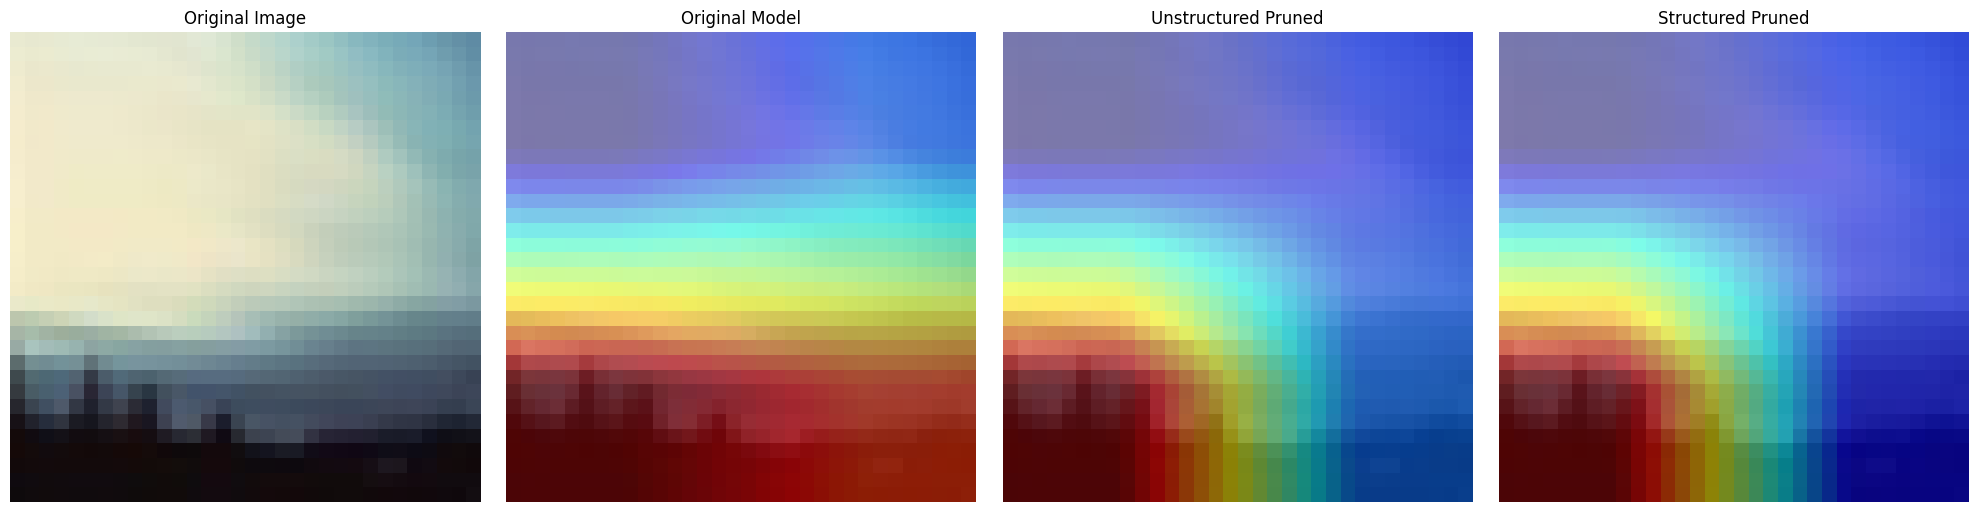

In [31]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.utils.prune as prune

original_model = VGG(make_layers(cfg, batch_norm=True), num_classes=100).to(DEVICE)
state_dict = torch.hub.load_state_dict_from_url(WEIGHTS_URL, map_location=DEVICE)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'): k = k[7:]
    new_state_dict[k] = v

original_model.load_state_dict(new_state_dict)
original_model.eval()

unstructured_model = VGG(make_layers(cfg, batch_norm=True), num_classes=100).to(DEVICE)
unstructured_sd = torch.load(os.path.join(MODEL_SAVE_PATH, 'unstructured_pruned_vgg11_70.pth'))
unstructured_model.load_state_dict(unstructured_sd['state_dict'])
unstructured_model.eval()

base_model_for_struct = VGG(make_layers(cfg, batch_norm=True), num_classes=100).to(DEVICE)
base_model_for_struct.load_state_dict(new_state_dict)

sparsity_dict_struct = {
    'features.0': 0.4,
    'features.4': 0.15,
    'features.8': 0.35,
    'features.11': 0.3,
    'features.15': 0.4,
    'features.18': 0.45,
    'features.22': 0.4,
    'features.25': 0.7,
    'classifier.0': 0.7,
    'classifier.3': 0.7
}

structured_model = structured_prune_func(base_model_for_struct, sparsity_dict=sparsity_dict_struct)
structured_model.to(DEVICE)

structured_sd = torch.load(os.path.join(MODEL_SAVE_PATH, 'structured_pruned_vgg11_70.pth'))
structured_model.load_state_dict(structured_sd['state_dict'])
structured_model.eval()

transform_viz = transforms.Compose([
    transforms.ToTensor(),
])
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

viz_dataset = datasets.CIFAR100(root=DATA_DIR, train=False, download=True, transform=transform_viz)
norm_dataset = datasets.CIFAR100(root=DATA_DIR, train=False, download=True, transform=transform_norm)

idx = 8
img_viz, label = viz_dataset[idx]
img_norm = norm_dataset[idx][0].unsqueeze(0).to(DEVICE)
img_viz_np = np.float32(img_viz.permute(1, 2, 0))

models = [original_model, unstructured_model, structured_model]
titles = ["Original Model", "Unstructured Pruned", "Structured Pruned"]

target_layers = [model.features[25] for model in models]

cams = []
for model, target_layer in zip(models, target_layers):
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=img_norm, targets=None)[0, :]
    cam_image = show_cam_on_image(img_viz_np, grayscale_cam, use_rgb=True)
    cams.append(cam_image)

# --- 4. Plot the results ---
print("\n--- Grad-CAM Comparison [Task (a)] ---")
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(img_viz_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

for i, (cam_image, title) in enumerate(zip(cams, titles)):
    axes[i+1].imshow(cam_image)
    axes[i+1].set_title(title)
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

@torch.no_grad()
def benchmark_latency_on_loader(model, loader, device, n_warmup_epochs=1, n_test_epochs=5):
    model.eval()
    
    print(f"  > Warming up {model.__class__.__name__} for {n_warmup_epochs} epoch(s)...")
    for _ in range(n_warmup_epochs):
        for images, _ in loader:
            images = images.to(device)
            _ = model(images)
            
    print(f"  > Running benchmark for {n_test_epochs} epoch(s)...")
    epoch_times = []
    for _ in range(n_test_epochs):
        torch.cuda.synchronize()
        t_start = time.time()
        
        for images, _ in loader:
            images = images.to(device)
            _ = model(images)

        torch.cuda.synchronize()
        t_end = time.time()
        epoch_times.append(t_end - t_start)
    
    # Calculate average time per epoch
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    # Calculate average time per batch (latency)
    avg_batch_latency = (avg_epoch_time / len(loader)) * 1000 # convert to ms
    print(f"  > Avg. Latency: {avg_batch_latency:.2f} ms per batch")
    return avg_batch_latency



acc_orig = 70.79
acc_unstruct = 69.82
acc_struct = 68.30

# Measure Storage (On-Device)
size_orig = get_model_size(original_model, count_nonzero_only=False) / MiB
size_unstruct = get_model_size(unstructured_model, count_nonzero_only=True) / MiB
size_struct = get_model_size(structured_model, count_nonzero_only=False) / MiB

# Get Sparsity
sparsity_orig = 0.0
sparsity_unstruct = get_model_sparsity(unstructured_model) * 100
sparsity_struct = (1 - (size_struct / size_orig)) * 100

# Measure Latency (using the new benchmark function and test_loader)
print("\nMeasuring inference latency (avg. over 5 full test-set passes)...")
lat_orig = benchmark_latency_on_loader(original_model, test_loader, DEVICE, n_test_epochs=5)
lat_unstruct = benchmark_latency_on_loader(unstructured_model, test_loader, DEVICE, n_test_epochs=5)
lat_struct = benchmark_latency_on_loader(structured_model, test_loader, DEVICE, n_test_epochs=5)
print("Latency measurement complete.")

data = {
    "Metric": ["Test Accuracy (%)", "Target Sparsity (%)", "On-Device Size (MiB)", "Inference Latency (ms)"],
    "Original Model": [f"{acc_orig:.2f}", f"{sparsity_orig:.2f}", f"{size_orig:.2f}", f"{lat_orig:.2f}"],
    "Unstructured Pruned": [f"{acc_unstruct:.2f}", f"{sparsity_unstruct:.2f}", f"{size_unstruct:.2f}", f"{lat_unstruct:.2f}"],
    "Structured Pruned": [f"{acc_struct:.2f}", f"{sparsity_struct:.2f}", f"{size_struct:.2f}", f"{lat_struct:.2f}"]
}

df = pd.DataFrame(data)
print(df.to_markdown(index=False))


Measuring inference latency (avg. over 5 full test-set passes)...
  > Warming up VGG for 1 epoch(s)...
  > Running benchmark for 5 epoch(s)...
  > Avg. Latency: 81.47 ms per batch
  > Warming up VGG for 1 epoch(s)...
  > Running benchmark for 5 epoch(s)...
  > Avg. Latency: 80.92 ms per batch
  > Warming up VGG for 1 epoch(s)...
  > Running benchmark for 5 epoch(s)...
  > Avg. Latency: 79.92 ms per batch
Latency measurement complete.

### Task (c): Model Comparison ###
| Metric                 |   Original Model |   Unstructured Pruned |   Structured Pruned |
|:-----------------------|-----------------:|----------------------:|--------------------:|
| Test Accuracy (%)      |            70.79 |                 69.82 |               68.3  |
| Target Sparsity (%)    |             0    |                 69.65 |               69.24 |
| On-Device Size (MiB)   |            37.39 |                 11.35 |               11.5  |
| Inference Latency (ms) |            81.47 |                 80.